# DACON 해외 축구 선수 이적료 예측
## Regression - LightGBM
[참고 노트북](https://dacon.io/competitions/official/235538/codeshare/5071?page=1&dtype=recent)
### 데이터 셋
[DACON](https://dacon.io/competitions/open/235538/data)  

### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

In [2]:
def reg_score(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
    MAE = np.mean( np.abs((y_true - y_pred) / y_true) )
    NMAE =mean_absolute_error(y_true, y_pred)/ np.mean( np.abs(y_true) )
    MAPE = np.mean( np.abs((y_true - y_pred) / y_true) ) *100
    R2 = r2_score(y_true, y_pred)
    
    print(f"MSE: {np.round(MSE, 3)}\nRMSE: {np.round(RMSE, 3)}\nMAE: {np.round(MAE, 3)}\nNMAE: {np.round(NMAE, 3)}\nMAPE: {np.round(MAPE, 3)}\nR2: {np.round(R2, 3)}")


### Data Load

In [3]:
path = glob.glob("data/*")
path

['data\\FIFA_test.csv', 'data\\FIFA_train.csv', 'data\\submission.csv']

In [4]:
train = pd.read_csv(path[1])
test = pd.read_csv(path[0])
submit = pd.read_csv(path[2])

train.shape, test.shape, submit.shape

((8932, 12), (3828, 11), (3828, 2))

### 기본 정보

In [5]:
display(train.sample(3))
display(test.sample(3))

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
4996,8634,A. Baclet,32,europe,2019,ST,left,1.0,66,66,2.0,525000.0
1862,3150,S. Sam,30,europe,2019,MF,left,2.0,72,72,3.0,2900000.0
6394,11456,Paulo Vítor,29,south america,2021,GK,right,1.0,63,64,1.0,290000.0


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
1461,5641,Y. Toyokawa,23,asia,2020,ST,right,1.0,69,74,3.0
3711,16128,M. Ndione,18,europe,2020,ST,right,1.0,54,64,2.0
2951,12353,M. Gutiérrez,26,south america,2018,MF,right,1.0,62,63,2.0


(출처: 데이콘)
- id : 선수 고유의 아이디
- name : 이름
- age : 나이
- continent : 선수들의 국적이 포함되어 있는 대륙입니다
- contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
- position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
- prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
- reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
- stat_overall : 선수의 현재 능력치 입니다.
- stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
- stat_skill_moves : 선수의 개인기 능력치 입니다.
- value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다

### 결측치 확인

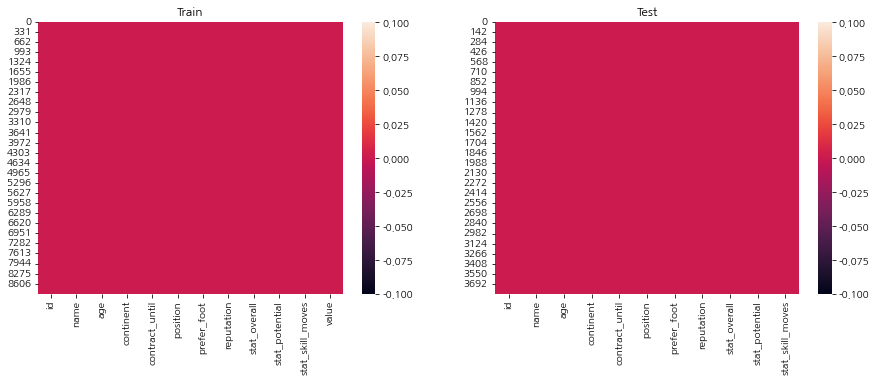

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

_ = sns.heatmap(train.isnull(), ax=ax[0]).set_title("Train")
_ = sns.heatmap(test.isnull(), ax=ax[1]).set_title("Test")

### 데이터 확인
이산형과 연속형 데이터 나누기

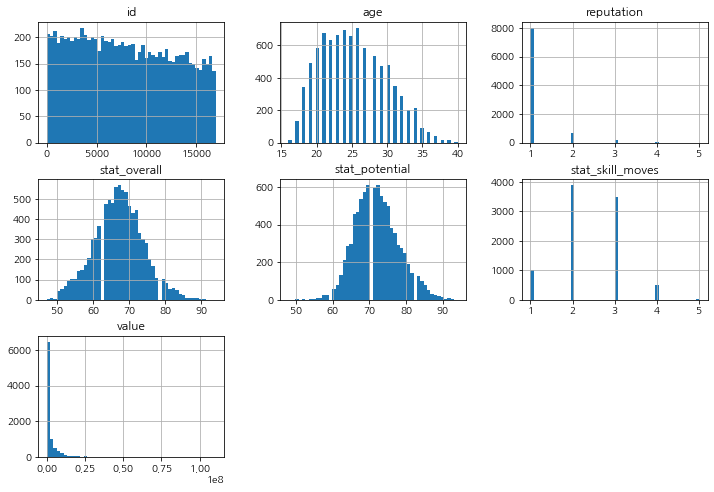

In [7]:
_ = train.hist(bins=50, figsize=(12, 8))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [9]:
# 연속형
nums = ["age", "stat_overall", "stat_potential"]
# 이산형
noms = ["continent", "position", "prefer_foot", "reputation", "stat_skill_moves"]

#### value 처리
`value`의 경우 너무 한쪽으로 치우쳐 있음  
`log`를 이용해 처리해줌

In [5]:
train["value(log scale)"] = np.log1p(train["value"])

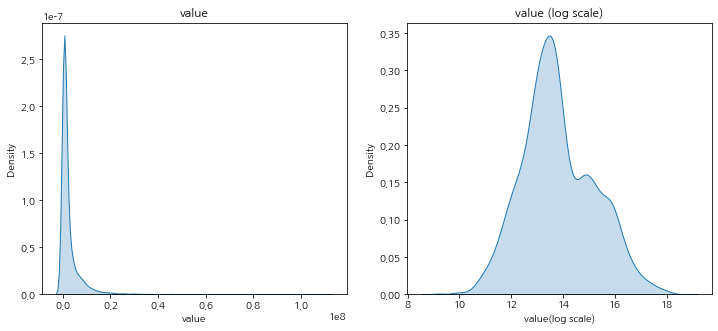

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

_ = sns.kdeplot(data=train, x="value", shade=True, ax=ax[0]).set_title("value")
_ = sns.kdeplot(data=train, x="value(log scale)", shade=True, ax=ax[1]).set_title("value (log scale)")

#### contract_until 처리

In [6]:
train["contract_until"] = pd.to_datetime(train["contract_until"]).dt.year
test["contract_until"] = pd.to_datetime(train["contract_until"]).dt.year

#### 연속형 데이터

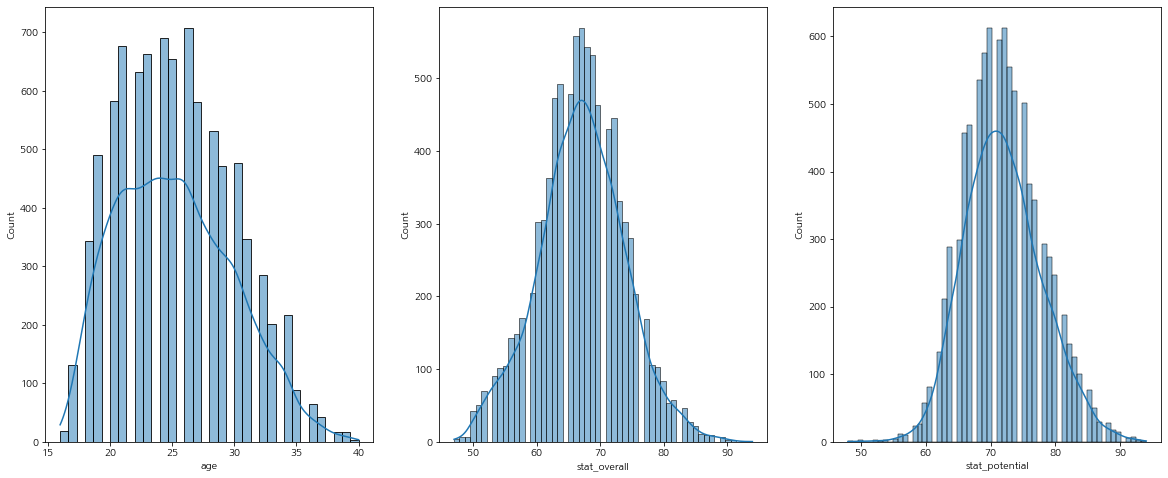

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=len(nums), figsize=(20, 8))

for col, ax in zip(nums, ax):
    _ = sns.histplot(data=train, x=col, kde=True, ax=ax)

#### 이산형 데이터

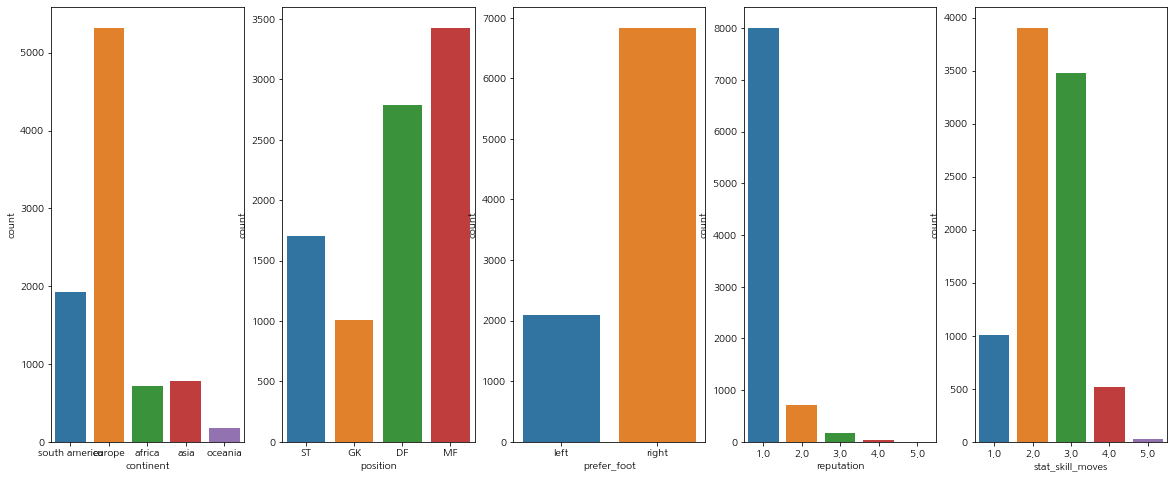

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=len(noms), figsize=(20, 8))

for col, ax in zip(noms, ax):
    _ = sns.countplot(data=train, x=col, ax=ax)

### 기술 통계량
이상치를 찾아봄

In [15]:
train.describe()

,id,age,contract_until,reputation,stat_overall,stat_potential,stat_skill_moves,value,value(log scale)
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03,8932.000000
mean,7966.775750,25.209136,2020.194357,1.130878,67.091133,71.997201,2.401702,2.778673e+06,13.793901
std,4844.428521,4.635515,1.266901,0.423792,6.854910,5.988147,0.776048,5.840982e+06,1.401709
min,0.000000,16.000000,2018.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04,9.210440
25%,3751.750000,21.000000,2019.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05,12.834684
50%,7696.500000,25.000000,2020.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05,13.623140
75%,12082.250000,28.000000,2021.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06,14.771022
max,16948.000000,40.000000,2026.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08,18.520526


In [16]:
train.describe(include="object")

,name,continent,position,prefer_foot
count,8932,8932,8932,8932
unique,8932,5,4,2
top,L. Messi,europe,MF,right
freq,1,5322,3428,6837


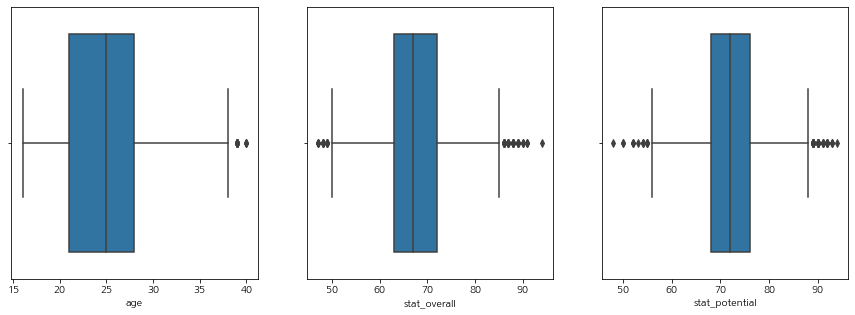

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=len(nums), figsize=(15, 5))

for col, ax in zip(nums, ax):
    _ = sns.boxplot(data=train, x=col, ax=ax)

이상치가 존재함

### 상관 계수

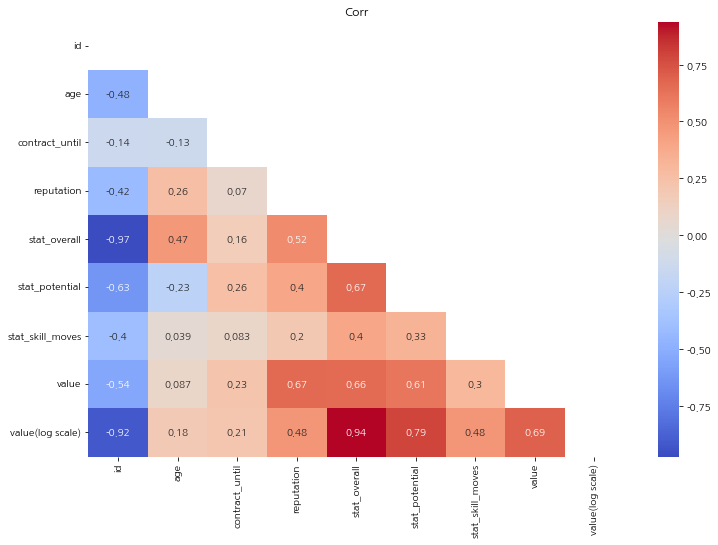

In [18]:
plt.figure(figsize=(12, 8))
_ = sns.heatmap(train.corr(), cmap="coolwarm", annot=True, mask=np.triu(np.ones_like(train.corr()))).set_title("Corr")

`value`에 대한 `stat_overall (현재 능력치)`와 `stat_potential (성장 가능성)`의 관계성이 비슷함  
의미하는 바도 비슷함으로, 파생 변수를 만들어 하나의 특성을 사용하면 좋을꺼 같다는 생각을 함

#### id - value (유명도 별)

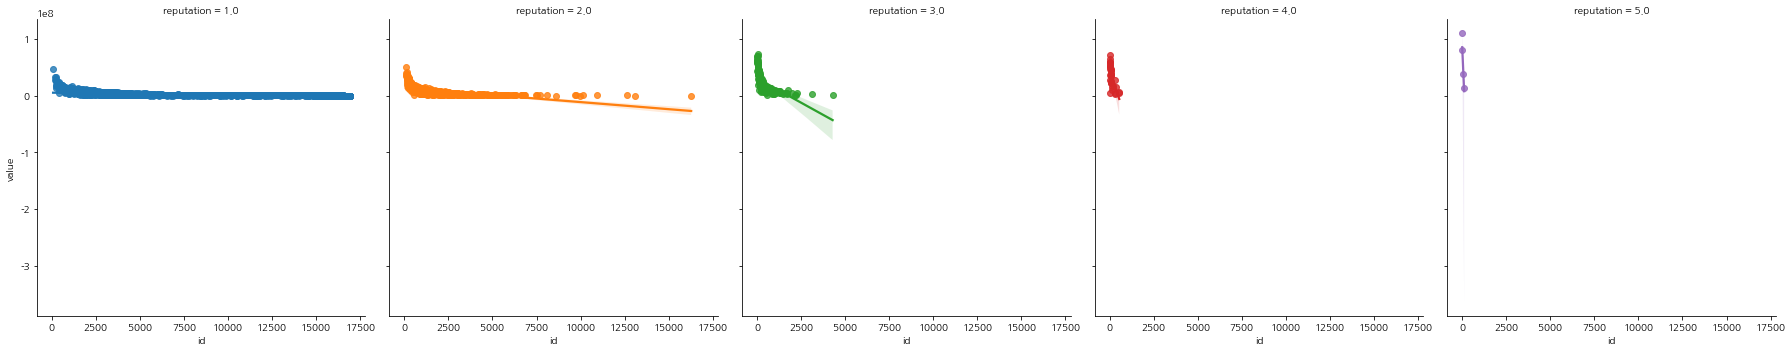

In [19]:
_ = sns.lmplot(data=train, x="id", y="value", col="reputation", hue="reputation")

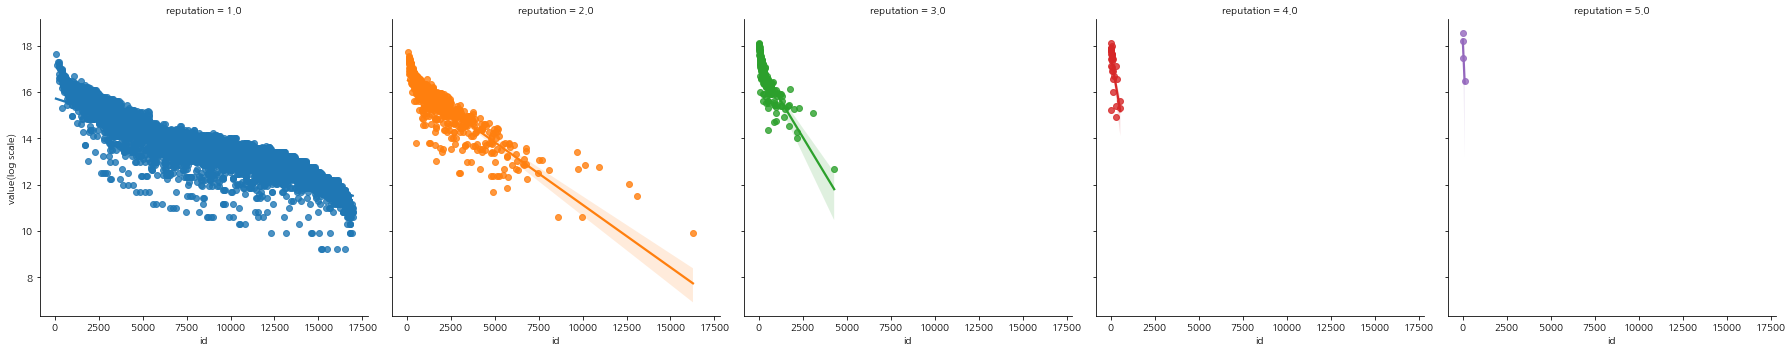

In [20]:
_ = sns.lmplot(data=train, x="id", y="value(log scale)", col="reputation", hue="reputation")

#### age - value (유명도별)

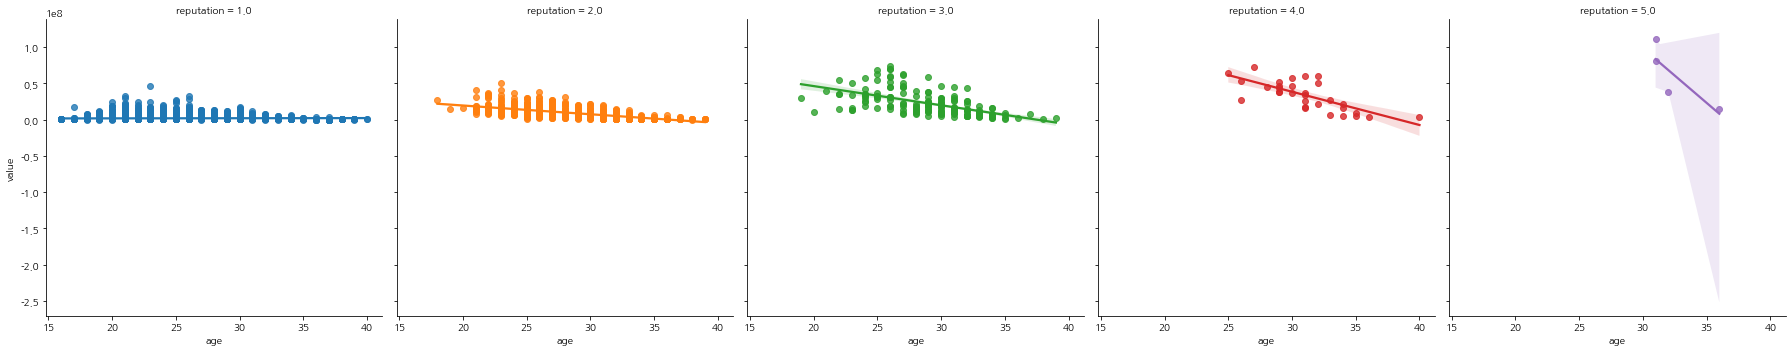

In [21]:
_ = sns.lmplot(data=train, x="age", y="value", col="reputation", hue="reputation")

#### stat_overall & stat_potential

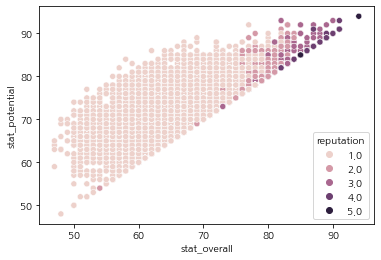

In [22]:
_ = sns.scatterplot(data=train, x="stat_overall", y="stat_potential", hue="reputation")

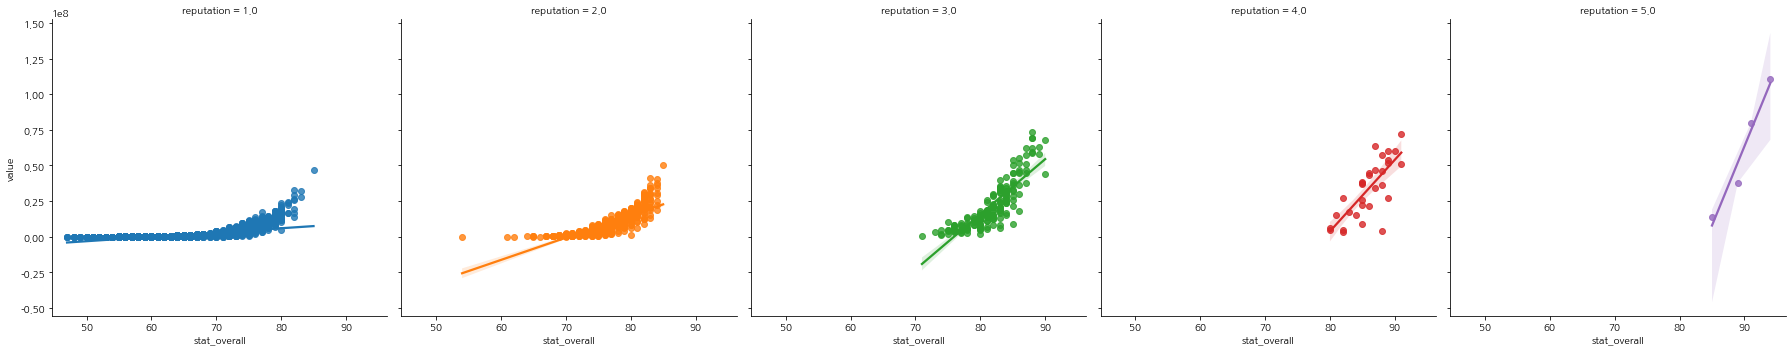

In [23]:
_ = sns.lmplot(data=train, x="stat_overall", y="value", col="reputation", hue="reputation")

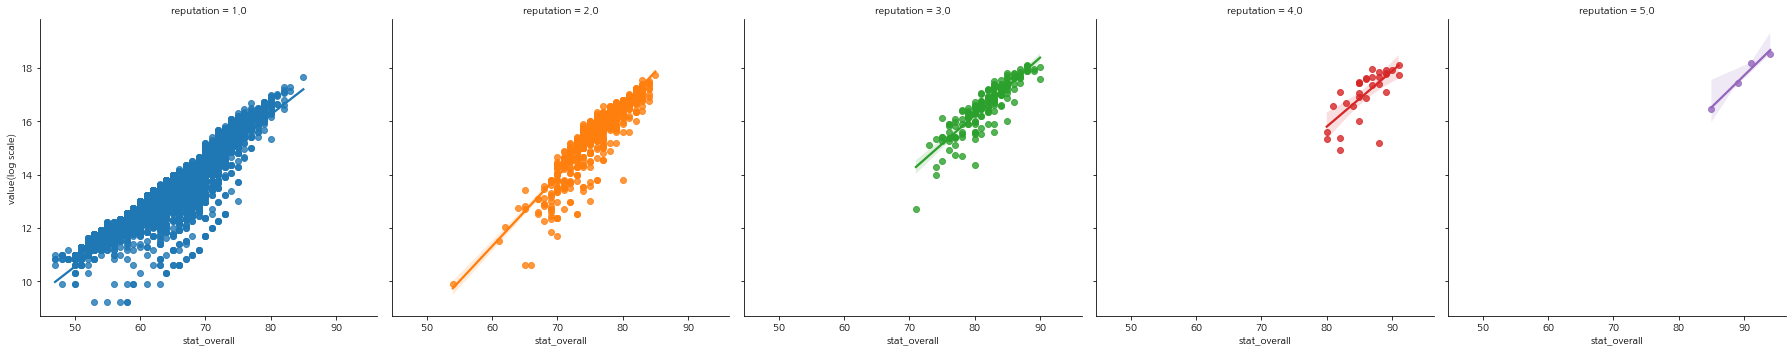

In [24]:
_ = sns.lmplot(data=train, x="stat_overall", y="value(log scale)", col="reputation", hue="reputation")

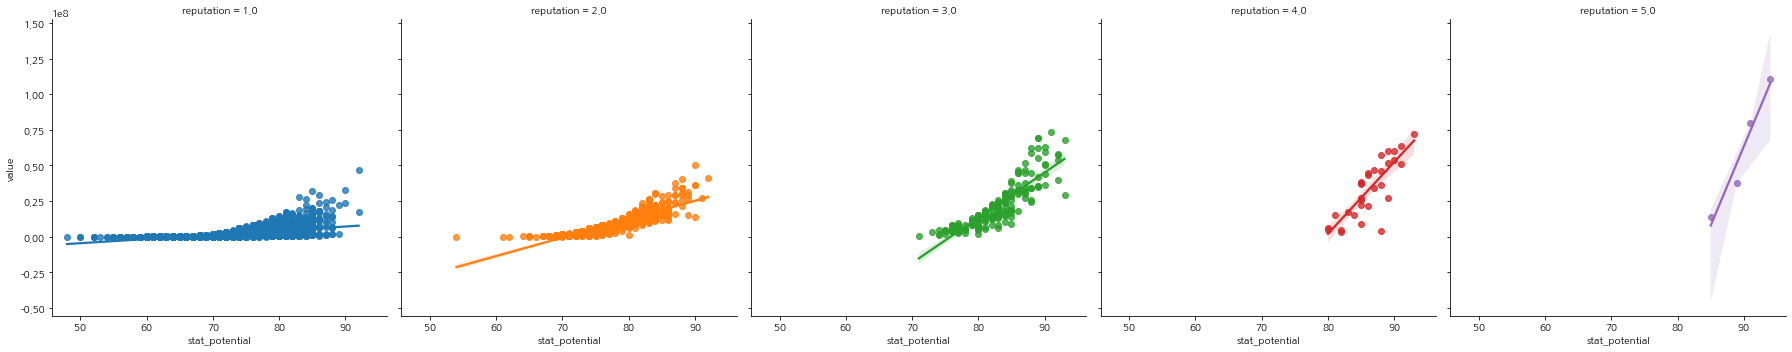

In [25]:
_ = sns.lmplot(data=train, x="stat_potential", y="value", col="reputation", hue="reputation")

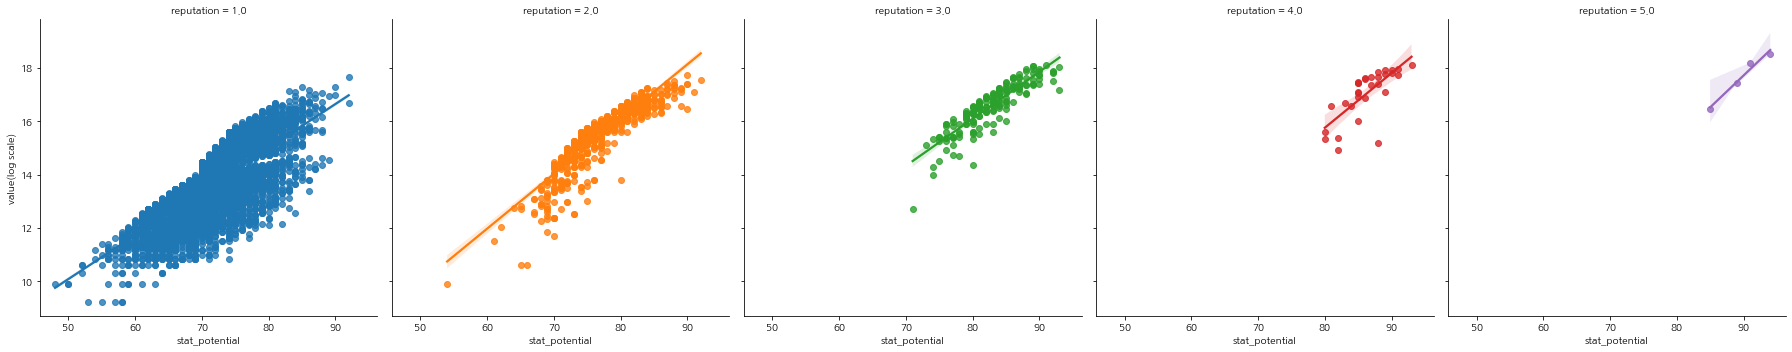

In [26]:
_ = sns.lmplot(data=train, x="stat_potential", y="value(log scale)", col="reputation", hue="reputation")

하나의 변수로 만들어 사용하는 것이 확실히 더 좋아보임

#### stat_skill_moves - value

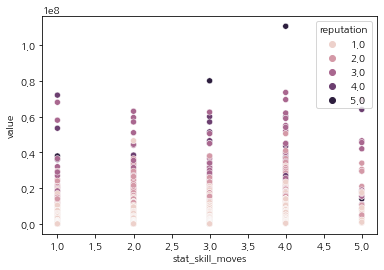

In [27]:
_ = sns.scatterplot(data=train, x="stat_skill_moves", y="value", hue="reputation")

### 파생변수 만들기

In [7]:
train["stat"] = (train["stat_overall"] + train["stat_potential"])/2
test["stat"] = (test["stat_overall"] + test["stat_potential"])/2

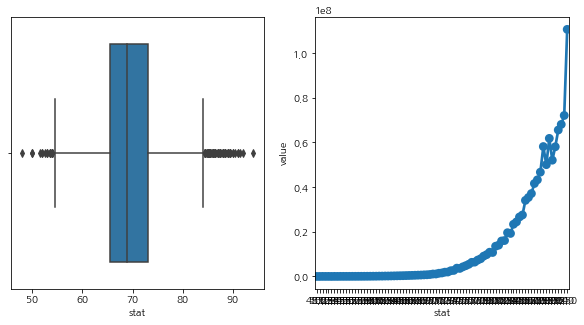

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
_ = sns.boxplot(data=train, x="stat", ax=ax[0])
_ = sns.pointplot(data=train, x="stat", y="value", ci=None, ax=ax[1])

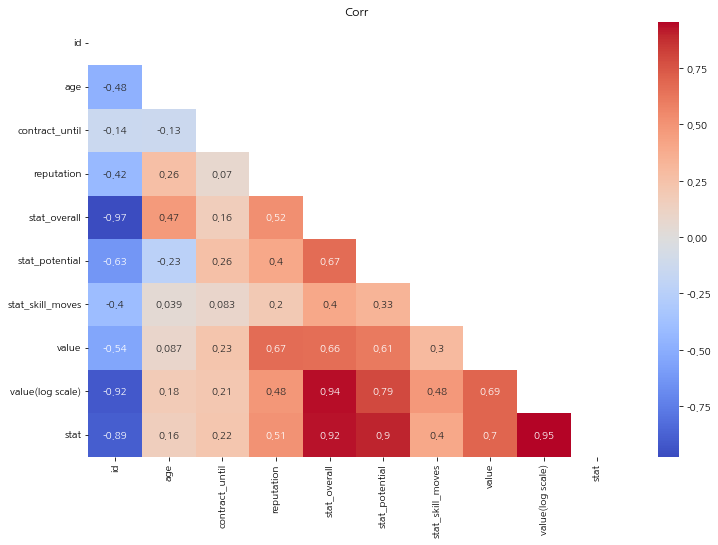

In [30]:
plt.figure(figsize=(12, 8))
_ = sns.heatmap(train.corr(), cmap="coolwarm", annot=True, mask=np.triu(np.ones_like(train.corr()))).set_title("Corr")

### 필요없는 행 버리기

In [8]:
train.drop(columns=["id", "name", "stat_overall", "stat_potential", "value", "continent"], axis=1, inplace=True)
test.drop(columns=["id", "name", "stat_overall", "stat_potential", "continent"], axis=1, inplace=True)

# train.drop(columns=["name", "stat", "value"], axis=1, inplace=True)
# test.drop(columns=["name", "stat"], axis=1, inplace=True)

### 범수형 데이터 -> 수치형 데이터

In [12]:
to_dummy = ["position", "prefer_foot"] #"continent"

In [13]:
train_dummy = []
test_dummy = []
for col in to_dummy:
    train_dummy.append(pd.get_dummies(train[col], drop_first=True))
    test_dummy.append(pd.get_dummies(test[col], drop_first=True))

In [14]:
train.drop(columns=to_dummy, inplace=True)
temp = pd.concat(train_dummy, axis=1)
train = pd.concat([train, temp], axis=1)

test.drop(columns=to_dummy, inplace=True)
temp = pd.concat(test_dummy, axis=1)
test = pd.concat([test, temp], axis=1)

### Train - LightGBM

In [15]:
label = "value(log scale)"
feature_names = train.columns.tolist()
feature_names.remove(label)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train[feature_names], train[label], test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (7145, 9)
y_train: (7145,)
X_test: (1787, 9)
y_test: (1787,)


In [18]:
model_lgbm = LGBMRegressor(n_estimators=400, learning_rate=0.1)

model_lgbm.fit(X_train, y_train)

LGBMRegressor(n_estimators=400)

In [19]:
y_pred = model_lgbm.predict(X_test)

reg_score(y_test, y_pred)

MSE: 0.018
RMSE: 0.136
MAE: 0.007
NMAE: 0.006
MAPE: 0.663
R2: 0.991


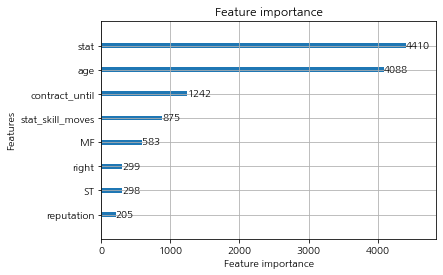

In [20]:
_ = plot_importance(model_lgbm)

### 제출

In [21]:
submit["value"] = np.expm1(model_lgbm.predict(test))

In [22]:
submit.to_csv("submit_lgbm_rmse_136.csv", index=False)